# Build Topic Modelling. 

In [1]:
# Python module. 
import re, os 
import pandas as pd
import spacy 
import umap, umap.plot 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import AgglomerativeClustering 
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation, NMF 
from sklearn.pipeline import Pipeline 

# # Unable to use this module. 
# import neuralcoref

# Change the current directory from (./notebook) to root directory. 
if not re.match(r".+/MADS-M2-estimating-news-impact-on-financial-market$", os.getcwd()): 
	os.chdir("../..") 

# For clearing safe warnings. Not important. 
from IPython.display import clear_output

# Custom modules. 
from source.modules.manage_files import ManageFiles
from source.modules.processor_topic import (
	resolve_coref, wikifier_extract, raw_token_input, 
	get_token_weight, get_center_component, get_topic_similarity 
)
from source.modules import visualizer 

# Custom configs. 
from source.config_py.config import DIR_MLTOPIC, PARAM_SEED, PARAM_N_TOPIC 

# Preview. 
print(os.getcwd()) 

/Users/lioneltay/.local/share/virtualenvs/MADS-M2-estimating-news-impact-on-financia-G1YPmgZm/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/Users/lioneltay/Dropbox/Courses/michigan_mads/SIADS_694_695_milestone_2_Eric_Gilbert/submission/MADS-M2-estimating-news-impact-on-financial-market


## Configurations (general). 

In [2]:
# Pandas DF config. 
pd.set_option("display.max_rows", 50, "display.max_columns", 50, "display.max_colwidth", 50)

# SpaCy configuration. 
nlp = spacy.load("en_core_web_sm") 

# File management setup. 
manage_files = ManageFiles() 

# For clearing the output. Not important. 
clear_output()

## Load news dataset. 

In [3]:
# Specify columns to use and renaming them. 
usecols  = ["Date published", "Url", "Category", "Section", "Headline", "Second headline", "Description", "Article text"] 

# Load dataset. 
df_cnn = manage_files.read_from_csv(filename="cnn_articles_v2.csv", usecols=usecols, parse_dates=usecols[:1]) 

# Rename columns. 
df_cnn.columns = [c.lower().replace(" ", "_") for c in df_cnn.columns] 

# Preview. 
df_cnn 

Read from (cnn_articles_v2.csv)


,date_published,category,section,url,headline,description,second_headline,article_text
0,2021-07-15 02:46:59,news,world,https://www.cnn.com/2021/07/14/world/tusimple-...,"There's a shortage of truckers, but TuSimple t...",The e-commerce boom has exacerbated a global t...,"There's a shortage of truckers, but TuSimple t...","(CNN)Right now, there's a shortage of truck d..."
1,2021-05-12 07:52:09,news,world,https://www.cnn.com/2021/05/12/world/ironhand-...,Bioservo's robotic 'Ironhand' could protect fa...,Working in a factory can mean doing the same t...,A robotic 'Ironhand' could protect factory wor...,(CNN)Working in a factory or warehouse can me...
2,2021-06-16 02:51:30,news,asia,https://www.cnn.com/2021/06/15/asia/swarm-robo...,This swarm of robots gets smarter the more it ...,"In a Hong Kong warehouse, a swarm of autonomou...",This swarm of robots gets smarter the more it ...,"(CNN)In a Hong Kong warehouse, a swarm of aut..."
3,2022-03-18 14:37:21,business,success,https://www.cnn.com/2022/03/18/success/pandemi...,"Two years later, remote work has changed milli...",Here's a look at how the pandemic reshaped peo...,"Two years later, remote work has changed milli...",The pandemic thrust the working world into a n...
4,2022-03-19 11:41:08,business,investing,https://www.cnn.com/2022/03/19/investing/march...,Why March is so volatile for stocks - CNN,March Madness isn't just for college basketbal...,Why March is so volatile for stocks,New York (CNN Business)March Madness isn't jus...
...,...,...,...,...,...,...,...,...
37944,2022-03-01 10:59:10,sport,sport,https://www.cnn.com/2022/03/01/sport/vladimir-...,Russian President Vladimir Putin is being stri...,Russian President Vladimir Putin has been stri...,Vladimir Putin is being stripped of his honora...,(CNN)Russian President Vladimir Putin has bee...
37945,2022-03-01 12:55:37,news,europe,https://www.cnn.com/2022/03/01/europe/nato-ukr...,"On NATO's doorstep, a former tourist hotspot i...",A long line of men snakes out of an unassuming...,"On NATO's doorstep, a former tourist hotspot i...","Lviv, Ukraine (CNN)A long line of men snakes o..."
37946,2022-03-01 11:54:44,sport,sport,https://www.cnn.com/2022/03/01/sport/mlb-deadl...,MLB is postponing Opening Day after owners and...,Major League Baseball (MLB) is postponing its ...,MLB is postponing Opening Day after owners and...,(CNN)Major League Baseball (MLB) is postponin...
37947,2013-01-12 01:42:49,news,europe,https://www.cnn.com/2013/01/11/world/europe/mi...,Mikhail Gorbachev Fast Facts - CNN,"Read CNN's Fast Facts on Mikhail Gorbachev, fo...",Mikhail Gorbachev Fast Facts,Here's a look at the life of Mikhail Gorbachev...


## Preprocessing. 

### Filter by categories. 

In [4]:
# Filter news categories. 
df_business = df_cnn[df_cnn["category"] == "business"] 

# Process datetime. 
df_business["date"] = df_business["date_published"].dt.date 
df_business["date"] = pd.to_datetime(df_business["date"]) 

# Will raise warnigns due to SettingWithCopyWriting, but not an issue. 
clear_output() 

# Preview. 
df_business["section"].unique(), "-----" * 5, df_business.dtypes

(array(['success', 'investing', 'energy', 'perspectives', 'business-food',
        'media', 'business', 'tech', 'business-india', 'economy', 'homes',
        'business-money', 'cars', 'intl_business'], dtype=object),
 '-------------------------',
 date_published     datetime64[ns]
 category                   object
 section                    object
 url                        object
 headline                   object
 description                object
 second_headline            object
 article_text               object
 date               datetime64[ns]
 dtype: object)

### Remove unavailable headlines. 

In [5]:
# Check if there's any empty headline and url. 
df_business.isnull().sum()

date_published     0
category           0
section            0
url                0
headline           0
description        0
second_headline    0
article_text       0
date               0
dtype: int64

### Resolve co-referencing. 

In [6]:
# random_text_for_testing = '''
# 	Elon Musk is a business magnate, industrial designer, and engineer. 
# 	He is the founder, CEO, CTO, and chief designer of SpaceX. 
# 	He is also early investor, CEO, and product architect of Tesla, 
# 	Inc. He is also the founder of The Boring Company and the 
# 	co-founder of Neuralink. A centibillionaire, Musk became the richest 
# 	person in the world in January 2021, with an estimated net worth of 
# 	$185 billion at the time, surpassing Jeff Bezos. Musk was born to a 
# 	Canadian mother and South African father and raised in Pretoria, South 
# 	Africa. He briefly attended the University of Pretoria before 
# 	moving to Canada aged 17 to attend Queen's University. He transferred 
# 	to the University of Pennsylvania two years later, where he 
# 	received dual bachelor's degrees in economics and physics. He moved 
# 	to California in 1995 to attend Stanford University, but decided instead 
# 	to pursue a business career. He went on co-founding a web software 
# 	company Zip2 with he brother Kimbal Musk.
# '''

# # Append (neuralcoref) to the last pipeline. 
# neuralcoref.add_to_pipe(nlp)

# # Identify the co-referencing part for the body text.
# resolve_coref(random_text_for_testing, nlp) 

### Extract entities from the articles. 

In [7]:
# random_text_for_testing = '''
# 	Elon Musk is a business magnate, industrial designer, and engineer. 
# 	Elon Musk is the founder, CEO, CTO, and chief designer of SpaceX. 
# 	Elon Musk is also early investor, CEO, and product architect of Tesla, 
# 	Inc. Elon Musk is also the founder of The Boring Company and the 
# 	co-founder of Neuralink. A centibillionaire, Musk became the richest 
# 	person in the world in January 2021, with an estimated net worth of 
# 	$185 billion at the time, surpassing Jeff Bezos. Musk was born to a 
# 	Canadian mother and South African father and raised in Pretoria, South 
# 	Africa. Elon Musk briefly attended the University of Pretoria before 
# 	moving to Canada aged 17 to attend Queen's University. Elon Musk transferred 
# 	to the University of Pennsylvania two years later, where Elon Musk 
# 	received dual bachelor's degrees in economics and physics. Elon Musk moved 
# 	to California in 1995 to attend Stanford University, but decided instead 
# 	to pursue a business career. Elon Musk went on co-founding a web software 
# 	company Zip2 with Elon Musk brother Kimbal Musk.
# '''

# # Extract entities. 
# wikifier_extract(random_text_for_testing, lang="en", threshold=0.8) 

### Save the extracted entities. 

In [8]:
# # Uncomment this part if you wanna rerun the Wikifier extraction part. 

# # Make a copy to avoid overwriting the original. 
# df_business_ents = df_business.copy() 

# # Extract entities for each articles. This will take around 
# # 5 seconds for each (article_text). If the total row is 850, 
# # then it will take 1.5 hour to complete the process. 
# df_business_ents["wikifier_extract"] = df_business_ents["article_text"].apply(
# 	lambda x: wikifier_extract(x, lang="en", threshold=0.8) 
# ) 

# # Save the dataset to avoid rerunning the Wikifier extraction. 
# df_business_ents.index.name = "headline_id" 
# manage_files.write_to_parquet(df_business_ents, filename="cnn_news_business.parquet", index=True) 

# # Preview. 
# df_business_ents

In [9]:
# Load the cached dataset containing the entities. 
df_business_ents = manage_files.read_from_parquet(filename="cnn_news_business.parquet") 

# Preview. 
df_business_ents 

Read from (cnn_news_business.parquet)


,date_published,category,section,url,headline,description,second_headline,article_text,date,wikifier_extract,entities,pos_tags
headline_id,,,,,,,,,,,,
3,2022-03-18 14:37:21,business,success,https://www.cnn.com/2022/03/18/success/pandemi...,"Two years later, remote work has changed milli...",Here's a look at how the pandemic reshaped peo...,"Two years later, remote work has changed milli...",The pandemic thrust the working world into a n...,2022-03-18,"{'entities': {'characters': [[array([ 0, 11]) ...","{'characters': [[[ 0 11], [ 4 11], [922 933], ...","{'adjectives': ['new', 'new', 'normal', 'remot..."
4,2022-03-19 11:41:08,business,investing,https://www.cnn.com/2022/03/19/investing/march...,Why March is so volatile for stocks - CNN,March Madness isn't just for college basketbal...,Why March is so volatile for stocks,New York (CNN Business)March Madness isn't jus...,2022-03-19,"{'entities': {'characters': [[array([0, 7])], ...","{'characters': [[[0 7]], [[10 12]], [[10 21]],...","{'adjectives': ['apt', 'different', 'first', '..."
5,2022-03-20 11:36:43,business,investing,https://www.cnn.com/2022/03/20/investing/stock...,Stocks week ahead: Big Oil rakes in billions a...,"As crude prices surge, oil companies are rakin...",Big Oil rakes in billions as prices soar. Lawm...,A version of this story first appeared in CNN ...,2022-03-20,"{'entities': {'characters': [[array([42, 44]) ...","{'characters': [[[42 44], [140 142], [6077 607...","{'adjectives': ['first', 'enormous', 'extra', ..."
6,2022-03-18 14:26:26,business,energy,https://www.cnn.com/2022/03/18/energy/oil-russ...,Oil 'emergency': Work from home and drive slow...,Governments around the world must consider dra...,Oil 'emergency': Work from home and drive slow...,New York (CNN Business)Governments around the ...,2022-03-18,"{'entities': {'characters': [[array([0, 7])], ...","{'characters': [[[0 7]], [[10 12]], [[10 21]],...","{'adjectives': ['drastic', 'global', 'least', ..."
7,2022-03-20 12:57:36,business,perspectives,https://www.cnn.com/2022/03/20/perspectives/im...,Opinion: Technology is transforming the nature...,The convenience of digital payments to both co...,Technology is transforming the nature of money...,This interview has been edited from its origin...,2022-03-20,"{'entities': {'characters': [[array([105, 137]...","{'characters': [[[105 137], [109 137], [728 75...","{'adjectives': ['original', 'senior', 'latest'..."
...,...,...,...,...,...,...,...,...,...,...,...,...
10407,2022-01-13 22:27:26,business,business,https://www.cnn.com/2022/01/13/business/us-sup...,Nation's top trade groups hail SCOTUS ruling a...,The nation's largest industry trade groups are...,Nation's top trade groups hail SCOTUS ruling a...,(CNN Business)The nation's largest industry t...,2022-01-13,"{'entities': {'characters': [[array([2, 4])], ...","{'characters': [[[2 4]], [[ 2 13]], [[ 6 13], ...","{'adjectives': ['largest', 'low', 'nationwide'..."
10408,2022-01-04 22:43:13,business,business,https://www.cnn.com/2022/01/04/business/traffi...,Port of Los Angeles traffic sets record - CNN,A record-setting 10.7 million 20-foot containe...,Port of Los Angeles traffic sets record in 2021,(CNN)A record-setting 10.7 million 20-foot co...,2022-01-04,"{'entities': {'characters': [[array([2, 4])], ...","{'characters': [[[2 4]], [[74 77], [233 236], ...","{'adjectives': ['previous', 'executive', 'amer..."
10409,2021-12-06 18:26:07,business,business,https://www.cnn.com/2021/12/06/business/ford-r...,"Ford delays return to office for 30,000 worker...",Ford Motor Co. is pushing its return-to-office...,"Ford delays return to office for 30,000 worker...",New York (CNN Business)Ford Motor Co. is pushi...,2021-12-06,"{'entities': {'characters': [[array([0, 7])], ...","{'characters': [[[0 7]], [[10 12]], [[10 21]],...","{'adjectives': ['return-to-office', 'new', 'co..."


### Identify the response error from Wikifier API. 

In [10]:
# # Headline ID related to POS tags. 
# # 725 	{'adjectives': None, 'adverbs': None, 'nouns':...
# # 923 	{'adjectives': None, 'adverbs': None, 'nouns':...
# # 925 	{'adjectives': None, 'adverbs': None, 'nouns':...
# # 985 	{'adjectives': None, 'adverbs': None, 'nouns':...
# # 6057 	{'adjectives': None, 'adverbs': None, 'nouns':...

# # Headline ID related to entities. 
# # 725      None
# # 913      None
# # 923      None
# # 925      None
# # 958      None
# # 985      None
# # 1377     None
# # 3970     None
# # 6057     None
# # 10045    None

# # Run the headline ID above to identify the error after adjusting the (try) statement. 
# # Usually if POS tag has an empty result, it is due to issue related to long characters. 
# # The maximum # of character is 25,000. 
# wikifier_res = wikifier_extract(df_business.loc[923, "article_text"], lang="en", threshold=0.8) 

print(
	df_business_ents.loc[df_business_ents["entities"].str["title"].isnull(), "entities"], 
	"\n", "-----" * 5, "\n", 
	df_business_ents.loc[df_business_ents["pos_tags"].str["verbs"].isnull(), "pos_tags"], 
) 

headline_id
725      {'characters': None, 'dblabel': None, 'enlabel...
913      {'characters': None, 'dblabel': None, 'enlabel...
923      {'characters': None, 'dblabel': None, 'enlabel...
925      {'characters': None, 'dblabel': None, 'enlabel...
958      {'characters': None, 'dblabel': None, 'enlabel...
985      {'characters': None, 'dblabel': None, 'enlabel...
1377     {'characters': None, 'dblabel': None, 'enlabel...
3970     {'characters': None, 'dblabel': None, 'enlabel...
6057     {'characters': None, 'dblabel': None, 'enlabel...
10045    {'characters': None, 'dblabel': None, 'enlabel...
Name: entities, dtype: object 
 ------------------------- 
 headline_id
725     {'adjectives': None, 'adverbs': None, 'nouns':...
923     {'adjectives': None, 'adverbs': None, 'nouns':...
925     {'adjectives': None, 'adverbs': None, 'nouns':...
985     {'adjectives': None, 'adverbs': None, 'nouns':...
6057    {'adjectives': None, 'adverbs': None, 'nouns':...
Name: pos_tags, dtype: object


### Vectorize the entities. 

In [11]:
# Get the sub-themes or entities from entities (dict) object. 
df_business_ents["theme_sub"] = df_business_ents["entities"].str["title"] 
print("Total nulls befr drop:", df_business_ents["theme_sub"].isnull().sum()) 

# Remove rows not containing any sub-themes or entities. 
df_business_ents = df_business_ents.dropna(subset=["theme_sub"], axis="index") 
print("Total nulls aftr drop:", df_business_ents["theme_sub"].isnull().sum()) 

# Preview. 
df_business_ents["theme_sub"]

Total nulls befr drop: 10
Total nulls aftr drop: 0


headline_id
3        [COVID-19 pandemic, Employment, World, Learnin...
4        [New York City, CNN, CNN Business, Business, C...
5        [CNN, CNN Business, Business, Human rights, Ne...
6        [New York City, CNN, CNN Business, Business, G...
7        [International Monetary Fund, Money, Finance, ...
                               ...                        
10407    [CNN, CNN Business, Business, Industrial Revol...
10408    [CNN, Port, Port of Los Angeles, Los Angeles, ...
10409    [New York (state), CNN, CNN Business, Business...
10410    [New York (state), CNN, CNN Business, Business...
10415    [Unmanned aerial vehicle, Quadcopter, Aerial p...
Name: theme_sub, Length: 844, dtype: object

In [12]:
# Vectorize the list of entities. 
vectorizer = TfidfVectorizer(analyzer=raw_token_input) 
vectorizer.fit_transform(df_business_ents["theme_sub"]) 

print("Total tokens:", len(vectorizer.vocabulary_)) 

# Preview. 
vectorizer.vocabulary_ 

Total tokens: 8229


{'COVID-19 pandemic': 1044,
 'Employment': 2365,
 'World': 8095,
 'Learning': 4178,
 'Company': 1563,
 'Corporation': 1680,
 'Business': 1010,
 'President of the United States': 5770,
 'Telecommuting': 7171,
 'Socialization': 6669,
 'World War I': 8109,
 'Brand': 923,
 'Hybrid (biology)': 3457,
 'Cross country running': 1755,
 'United States': 7585,
 'Chelsea F.C.': 1292,
 'California': 1071,
 'Alabama': 205,
 'Jesus': 3832,
 'San Francisco': 6330,
 'Zeus': 8202,
 'Human rights': 3437,
 'United States dollar': 7655,
 'Birmingham, Alabama': 809,
 'Time': 7350,
 'Cost of living': 1688,
 'Poverty': 5736,
 'Same-sex marriage': 6320,
 'Advance healthcare directive': 113,
 'Trade': 7423,
 'Student loan': 6966,
 'Mental health': 4635,
 'Knowledge': 4049,
 'Carlos Ortiz': 1171,
 'Food and Drug Administration': 2745,
 'Food': 2741,
 'Anxiety': 402,
 'Entrepreneurship': 2397,
 'Private sector': 5806,
 'Industrial Revolution': 3572,
 'Regulation': 6064,
 'Financial services': 2663,
 'Telephone': 

### Save the vectorizer. 

In [13]:
# # Uncomment this to cache the latest vectorizer. 

# # Cache the vectorized output. 
# manage_files.save_cache_pk(dir=DIR_MLTOPIC, filename="vectorizer_entities.pickle", object=vectorizer) 

# # Load and preview the output of the vectorizer. 
# vectorizer = manage_files.load_cache_pk(dir=DIR_MLTOPIC, filename="vectorizer_entities.pickle") 
# print("Total tokens:", len(vectorizer.vocabulary_)) 

# # Preview. 
# vectorizer.vocabulary_

## Develop models. 

### Build models. 

In [14]:
# The (theme_sub) is a list of list. 
X = df_business_ents["theme_sub"] 

# Model pipeline setup. 
# You can select the model by uncommenting and commenting it. 
mlpipe_topic = Pipeline(
    [
        ("vectorizer", TfidfVectorizer(analyzer=raw_token_input)), 
        ("nmf", NMF(n_components=PARAM_N_TOPIC, random_state=PARAM_SEED, init="nndsvd")), 
        # ("lsi", TruncatedSVD(n_components=PARAM_N_TOPIC, random_state=PARAM_SEED)), 
        # ("lda", LatentDirichletAllocation(n_components=PARAM_N_TOPIC, random_state=PARAM_SEED)), 
    ]
)

# Execute the topic clustering. 
X_latent_feature = mlpipe_topic.fit_transform(X) 
component = mlpipe_topic["nmf"].components_ 

### Model evaluation. 

In [15]:
# Get similarity score for each pair of topics. 
df_topic_sim = get_topic_similarity(component) 

# Plot. 
visualizer.plot_similarity(df_topic_sim, x="topic", y="to_compare", z="topic_similarity") 

alt.LayerChart(...)

### Model interpretation. 

In [16]:
feature_names = mlpipe_topic["vectorizer"].get_feature_names_out() 

# Get the token weight and terms. 
df_token_weight = get_token_weight(component, feature_names) 

# Plot. 
visualizer.plot_token_weight(df_token_weight, x="token_weight", y="topic_terms", column=5, xlim=(0,1)) 

alt.VConcatChart(...)

In [17]:
mapper = umap.UMAP(densmap=True, set_op_mix_ratio=.8, random_state=PARAM_SEED) 
mapper.fit(X_latent_feature) 

visualizer.plot_umap(mapper, X.index, X_latent_feature) 

OMP: Info #270: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Loading BokehJS ...

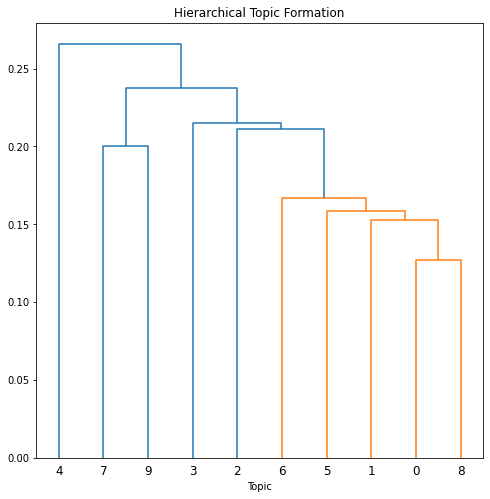

In [18]:
df_center_component = get_center_component(X.index, X_latent_feature) 

# This is a bottom-up clustering. 
cluster_agg = AgglomerativeClustering(n_clusters=None, distance_threshold=0, affinity="euclidean", linkage="ward") 
cluster_agg.fit(df_center_component) 

visualizer.plot_dendrogram(cluster_agg, truncate_mode="level", p=PARAM_N_TOPIC) 

### Save the models. 

In [19]:
# # Uncomment this to save the model. 

# # Cache the vectorized output. 
# mlpipe_name = "mlpipe_topic" 
# dev_status, version = manage_files.resume_version(DIR_MLTOPIC, dev_status=True) 
# manage_files.save_cache_pk(dir=DIR_MLTOPIC, filename=f"{dev_status}/{mlpipe_name}_v{version}.pickle", object=mlpipe_topic) 
# manage_files.update_version(DIR_MLTOPIC, version, dev_status=True) 
# mlpipe_topic_loaded = manage_files.load_cache_pk(dir=DIR_MLTOPIC, filename=f"{dev_status}/{mlpipe_name}_v{version}.pickle") 

Resumed version: (1) from (dev)
Save to (dev/mlpipe_topic_v1.pickle)
Updated version: (2) in (dev)
Load from (dev/mlpipe_topic_v1.pickle)
